In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier as xgb_s
from sklearn.metrics import f1_score
%matplotlib inline
%pylab inline
from matplotlib import pyplot as plt

from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble, learning_curve, metrics 
import numpy as np
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
data_train_raw = pd.read_csv('E:\\ya_ATMchallenge\\train_data_prepared.csv', sep=';')
data_test_raw = pd.read_csv('E:\\ya_ATMchallenge\\test_data_prepared.csv', sep=';')
#data_train_raw.head()

Задачи, которые я собираюсь здесь решить:
- изучить переобучение для бустинга и деревьев
- реализовать поиск по сетке для градиентного бустинга
- изучить апи и параметры бустинга

In [3]:
data_train=data_train_raw.copy()
data_train['cash_in_out']=data_train.cash_in_out.apply(lambda x : 0 if x=='Cash_Out' else 1)
data_train['display_type']=data_train.display_type.apply(lambda x : 0 if x=='Buttons' else 1)
data_train['scanner_code_reader']=data_train.scanner_code_reader.apply(lambda x : 0 if x=='2D' else 1)

data_test=data_test_raw.copy()
data_test['cash_in_out']=data_test.cash_in_out.apply(lambda x : 0 if x=='Cash_Out' else 1)
data_test['display_type']=data_test.display_type.apply(lambda x : 0 if x=='Buttons' else 1)
data_test['scanner_code_reader']=data_test.scanner_code_reader.apply(lambda x : 0 if x=='2D' else 1)

#искуственное разбиение для проверок с бейзлайном
data_train_trainPart, data_train_testPart = data_train[data_train.period < 20], data_train[data_train.period > 19]

#стандартный scaler
scaler = StandardScaler()
data_train_target = data_train.target
data_train = scaler.fit_transform(data_train.drop(['target', 'period'], axis=1))
data_test = scaler.transform(data_test.drop(['period'], axis=1))

data_train_trainPart_target = data_train_trainPart.target
data_train_testPart_target = data_train_testPart.target
data_train_trainPart = scaler.fit_transform(data_train_trainPart.drop(['target', 'period'], axis=1))
data_train_testPart = scaler.transform(data_train_testPart.drop(['target','period'], axis=1))

## Понастраиваем параметры случайного леса
В качестве базового алгоритма выберем градиентный бустинг. Определим для начала количество признаков для деревьем разной глубины, чтобы не переобучаться.
#### Сначала - с небольшой глубиной:

[ 565 1696 2827 3958 5089]
[0.61244604 0.43185292 0.49145428 0.513941   0.51205877]
[0.50093479 0.42007766 0.47465888 0.49016939 0.49828917]


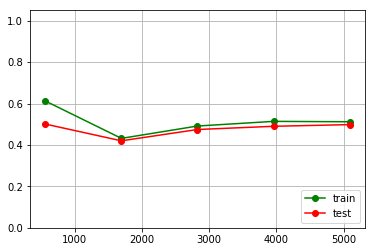

In [4]:
rf_classifier_low_depth = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 2, random_state = 1, n_jobs = -1)
train_sizes, train_scores, test_scores = learning_curve.learning_curve(rf_classifier_low_depth, data_train, data_train_target, 
                                                                       train_sizes=np.arange(0.1,1., 0.2), 
                                                                       cv=10, scoring='f1')
print (train_sizes)
print (train_scores.mean(axis = 1))
print (test_scores.mean(axis = 1))

pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')

#### Теперь с глубиной побольше

[ 565 1696 2827 3958 5089]
[0.9689635  0.93189234 0.93142147 0.91251568 0.8963328 ]
[0.54649473 0.49732639 0.5258361  0.55273651 0.5432526 ]


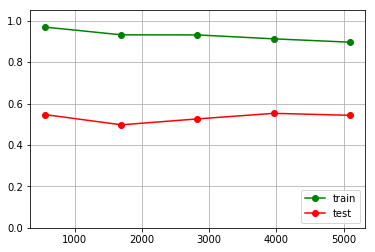

In [5]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state = 1, n_jobs = -1)
train_sizes, train_scores, test_scores = learning_curve.learning_curve(rf_classifier, data_train, data_train_target, 
                                                                       train_sizes=np.arange(0.1,1., 0.2), 
                                                                       cv=10, scoring='f1')
print (train_sizes)
print (train_scores.mean(axis = 1))
print (test_scores.mean(axis = 1))
pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')

### Исследуем зависимость качества от количества деревьев

[[0.47794118 0.46153846 0.46815835 0.49423394 0.47554806 0.53731343
  0.52258065 0.4673913  0.47191011 0.53957997]
 [0.52837573 0.48945148 0.49077491 0.54545455 0.50515464 0.54159292
  0.56293706 0.48262548 0.4625     0.55696203]
 [0.56692913 0.43946188 0.52877698 0.55652174 0.5083612  0.61824324
  0.62771285 0.52509653 0.55705996 0.61687414]
 [0.55       0.44494382 0.49345794 0.55755396 0.5516129  0.61666667
  0.64401294 0.52851711 0.57884972 0.63532764]
 [0.55905512 0.44897959 0.49168207 0.56781193 0.56219709 0.62706271
  0.64412238 0.52471483 0.60111317 0.64043419]
 [0.54545455 0.45248869 0.4962963  0.56624319 0.5664     0.62706271
  0.63870968 0.52591171 0.59889094 0.63333333]]


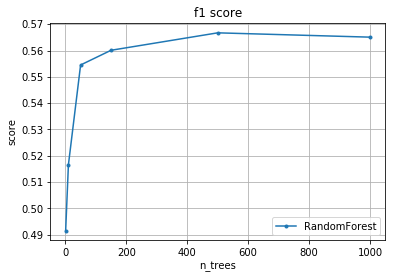

In [6]:
n_trees = [1,10,50,150,500,1000]# + list(range(10, 1000, 5))
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1, n_jobs = -1)
    score = cross_validation.cross_val_score(estimator, data_train, data_train_target, scoring = 'f1', cv = 10)    
    scoring.append(score)
scoring = np.asmatrix(scoring)
print (scoring)

pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('f1 score')
pylab.legend(loc='lower right')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

[[0.59618718 0.48728814 0.49537893 0.49689441 0.60856721 0.55696203
  0.6031746  0.50873786 0.55045872 0.56628057]
 [0.57418112 0.42523364 0.51205937 0.55797101 0.58105939 0.63636364
  0.63349917 0.5        0.57777778 0.63192905]
 [0.58188825 0.36714976 0.37591241 0.48506151 0.54515599 0.61273666
  0.63       0.51587302 0.58148148 0.63180828]
 [0.59099099 0.35207824 0.31261101 0.37983193 0.50401284 0.60732984
  0.59933775 0.51650485 0.57513915 0.63180828]
 [0.54212454 0.36450839 0.31578947 0.35897436 0.496      0.57092199
  0.58181818 0.56390977 0.52808989 0.63249727]
 [0.51962617 0.37019231 0.32212389 0.33108108 0.48673947 0.56624319
  0.57190083 0.52815534 0.53061224 0.63318777]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


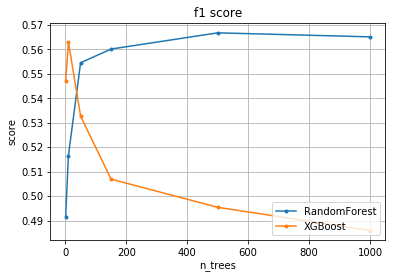

In [7]:

xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3, n_jobs = -1)
    score = cross_validation.cross_val_score(estimator, data_train, data_train_target, scoring = 'f1', cv = 10)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)
print (xgb_scoring)

pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('f1 score')
pylab.legend(loc='lower right')